In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.__version__

'1.4.0'

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

In [4]:
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imread

In [6]:
from random import shuffle, random
import cv2
from skimage import exposure
from tqdm import tqdm
from sklearn.utils import shuffle as shuffle_X_y
from math import pi, cos, sin, degrees, radians, atan2, sqrt

In [7]:
from preprocess import *
from behavioral_cloning import *

In [8]:
data_dir = 'data'

In [9]:
def parse_file_name(full_path):
    if '/' in full_path:
        return full_path.split('/')[-1]
    else:
        return full_path

In [10]:
def load_data(data_dir):
    colnames = ['center_img', 'left_img', 'right_img', 'steering_angle', 
                'throttle', 'break', 'speed']
    driving_log_pd = pd.read_csv('%s/driving_log.csv' % data_dir, sep=',', names=colnames)
    
    for colname in ['center_img', 'left_img', 'right_img']:
        driving_log_pd[colname] = [parse_file_name(x) for x 
                                   in driving_log_pd[colname].tolist()]
        
    return driving_log_pd

## Data Exploration

In [11]:
driving_log_pd = load_data(data_dir)

In [12]:
driving_log_pd.head()

,center_img,left_img,right_img,steering_angle,throttle,break,speed
0,center_2018_01_22_19_22_53_312.jpg,left_2018_01_22_19_22_53_312.jpg,right_2018_01_22_19_22_53_312.jpg,0.0,0.0,0.0,5.544637
1,center_2018_01_22_19_22_53_419.jpg,left_2018_01_22_19_22_53_419.jpg,right_2018_01_22_19_22_53_419.jpg,0.0,0.0,0.0,5.489003
2,center_2018_01_22_19_22_53_517.jpg,left_2018_01_22_19_22_53_517.jpg,right_2018_01_22_19_22_53_517.jpg,0.0,0.0,0.0,5.433926
3,center_2018_01_22_19_22_53_589.jpg,left_2018_01_22_19_22_53_589.jpg,right_2018_01_22_19_22_53_589.jpg,0.0,0.0,0.0,5.390263
4,center_2018_01_22_19_22_53_690.jpg,left_2018_01_22_19_22_53_690.jpg,right_2018_01_22_19_22_53_690.jpg,0.0,0.0,0.0,5.336177


In [13]:
def display_images(X, start_idx=0, end_idx=None,  columns = 5, use_gray=False, 
                   apply_fnc=None, figsize=(32,18)):
    if end_idx is None:
        end_idx = X.shape[0]
        
    if apply_fnc is None:
        apply_fnc = lambda image: image
        
    plt.figure(figsize=figsize)

    num_of_images = end_idx - start_idx
    rows = num_of_images / columns + 1
    
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(rows, columns, _i + 1)
        
        if use_gray:
            plt.imshow(apply_fnc(image), cmap="gray")
        else:
            plt.imshow(apply_fnc(image)) 
            
    plt.tight_layout()
            
    plt.show()

In [14]:
def read_imgs(img_dir, file_names):
    img_arr = []
    
    for file_name in file_names:
        img = imread('%s/%s' % (img_dir, file_name))
        img_arr.append(img)
        
    return np.stack(img_arr)

In [15]:
img_dir = '%s/IMG' % data_dir

In [207]:
sample_imgs = read_imgs(img_dir, driving_log_pd.iloc[8000:8010, 0].tolist())

In [215]:
preprocess_image(sample_imgs[0]).shape

(80, 160, 1)

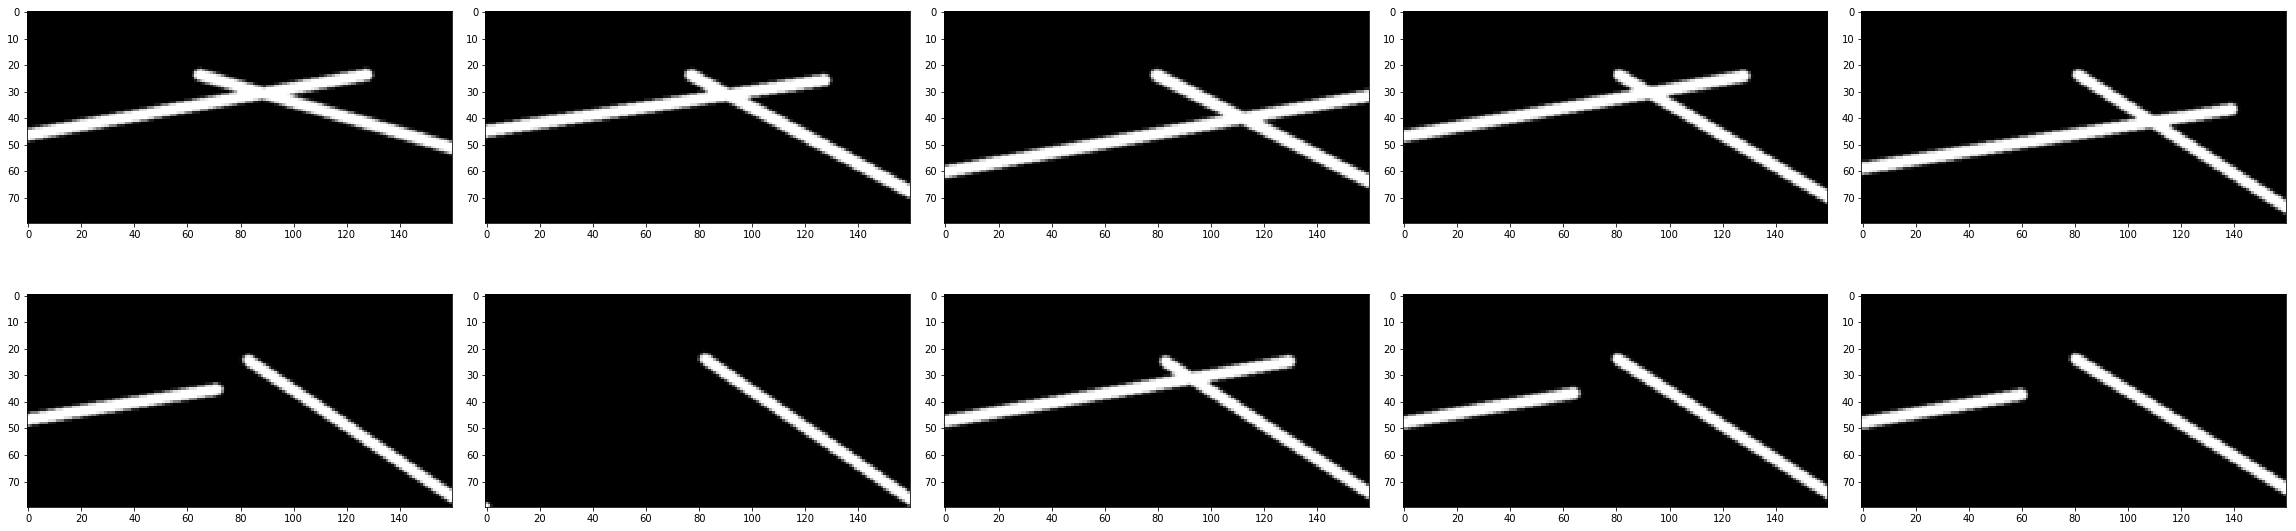

In [218]:
display_images(sample_imgs, columns=5, figsize=(32,12), 
               apply_fnc=lambda x: preprocess_image(x).reshape((80,160)),
               use_gray=True)

In [196]:
preprocess_image(sample_imgs[0], size=(128,128), apply_normalize=False).shape

NameError: name 'grayscale' is not defined

In [181]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [182]:
class Line(object):
    """
    Represents a line
    """
    def __init__(self, x1,y1,x2,y2):
        """
        Constructor for Line
        
        Parameters
        ----------
        x1, y1: int, int
            x,y of first point
        x2, y2: int, int
            x,y of second point
        """
        self.x1,self.y1,self.x2,self.y2 = x1,y1,x2,y2
        self._m = None
        self._b = None
        
    @property
    def m(self):
        """
        Slope of the line
        
        Returns
        -------
        float
            (y2-y1)/(x2-x1)
        """
        if self._m is None:
            if self.x2-self.x1 == 0:
                self._m = 0.0
            else:
                self._m = float(self.y2-self.y1)/float(self.x2-self.x1)
            
        return self._m
    
    @property
    def b(self):
        """
        x-intercept
        
        Returns
        -------
        float
            y1 - m*x1
        """
        if self._b is None:
            self._b = self.y1 - self.m*self.x1
            
        return self._b
    
    def find_x(self, y):
        """
        Based on y, find x.
        
        Parameters
        ----------
        y: int
            y coordinate
            
        Returns
        -------
        float
            corresponding x value
        """
        return (y-self.b)/self.m
    
    def find_y(self, x):
        """
        Based on x, find y.
        
        Parameters
        ----------
        x: int
            x coordinate
            
        Returns
        -------
        float
            corresponding y value
        """        
        return self.m*x + self.b

In [183]:
class LineCollection(object):
    """
    A collection of Lines.
    """
    def __init__(self, line_objs=[]):
        self.line_objs = line_objs
        self._mean_m = None
        self._mean_b = None
        self._top_y = None
        self._bottom_y = None
        
    @property
    def length(self):
        """
        Get number of lines.
        
        Returns
        -------
        int
            number of lines
        """
        return len(self.line_objs)
        
    @property
    def mean_m(self):
        """
        Get the mean slope of all lines.
        
        Returns
        -------
        float
            mean slope
        """
        if self._mean_m is None:
            if self.length == 0:
                self._mean_m = 0.0
            else:
                self._mean_m = float(np.mean([lo.m for lo in self.line_objs]))
            
        return self._mean_m
    
    @property
    def mean_b(self):
        """
        Get the mean x-intercept of all lines.
        
        Returns
        -------
        float
            mean x-intercept
        """
        if self._mean_b is None:
            if self.length == 0:
                self._mean_b = 0.0
            else:
                self._mean_b = float(np.mean([lo.b for lo in self.line_objs]))
            
        return self._mean_b
    
    @property
    def top_y(self):
        if self._top_y is None:
            min_y = None
        
            for line_obj in self.line_objs:
                if min_y is None or line_obj.y1 < min_y:
                    min_y = line_obj.y1
                    
                if min_y is None or line_obj.y2 < min_y:
                    min_y = line_obj.y2
            
            self._min_y = int(min_y)
            
        return self._top_y
    
    @property
    def bottom_y(self):
        """
        Find the bottom (furthest down) y value out of all lines.
        
        Returns
        -------
        int
            bottom y value
        """
        if self._bottom_y is None:
            max_y = 0
        
            for line_obj in self.line_objs:
                if line_obj.y1 > max_y:
                    max_y = line_obj.y1
                    
                if line_obj.y2 > max_y:
                    max_y = line_obj.y2
                
            self._bottom_y =  int(max_y)
            
        return self._bottom_y
    
    @property
    def top_y(self):
        """
        Find the top (furthest up) y value out of all lines.
        
        Returns
        -------
        int
            top y value
        """        
        if self._top_y is None:
            min_y = None
        
            for line_obj in self.line_objs:
                if min_y is None or line_obj.y1 < min_y:
                    min_y = line_obj.y1
                    
                if min_y is None or line_obj.y2 < min_y:
                    min_y = line_obj.y2
                
            if min_y is None:
                self._top_y = None
            else:
                self._top_y = int(min_y)
            
        return self._top_y
    
    def get_x(self, y):
        """
        Get x value based on the mean of the slope and x-intercept.
        
        Returns
        -------
        int
            x value
        """
        if self.mean_m == 0.0:
            return 0
       
        return int((y - self.mean_b)/self.mean_m)

    def get_mean_line_pts(self, bottom_y):
        """
        Get points for the mean line.  Extend the line to bottom_y.
        
        Parameters
        ----------
        bottom_y: int
            The bottom y for the line.
            
        Returns
        -------
        int, int, int, int
            Points for the line
        """
        if self.top_y is None:
            top_y = bottom_y
        else:
            top_y = self.top_y 
            
        top_x = self.get_x(top_y)
            
        bottom_x = self.get_x(bottom_y)
        return (top_x, top_y, bottom_x, bottom_y)

In [184]:
def draw_lines3(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draw lines on original image.  The lines will be separated by left and right lines.
    Horizontal lines will be filtered out. The means of the left and right lines will 
    be used to draw the lines on the original image.
    
    Parameters
    ----------
    img: numpy image array
        original image
    lines: list of (x1,y1,x2,y2)
        list of line points
    color: array of int
        RGB values for drawn lines
    thickness: int
        thickness of the drawn lines
    """    
    line_objs = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            curr_line_obj = Line(x1,y1,x2,y2)
            line_objs.append(curr_line_obj)
    
    left_line_objs = []
    right_line_objs = []
    for line_obj in line_objs:
        if abs(line_obj.m) > 0.15:
            if line_obj.m > 0.0:
                left_line_objs.append(line_obj)
            else:
                right_line_objs.append(line_obj)
            
    left_line_list = LineCollection(left_line_objs)
    right_line_list = LineCollection(right_line_objs)
    
    bottom_y = img.shape[0]
    
    mean_lines = [left_line_list.get_mean_line_pts(bottom_y), 
                  right_line_list.get_mean_line_pts(bottom_y)]

    for x1,y1,x2,y2 in mean_lines:
        cv2.line(img, (x1, y1), (x2,y2), color, thickness)

def hough_lines3(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines3(line_img, lines, thickness=8)
    return line_img

In [185]:
def _preprocess_image(img, x0=0, y0=48, x1=None, y1=112, size=(128, 128),
                     convert_to_rgb=False, apply_normalize=True):
    _img = img
    if not convert_to_rgb:
        _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

    _img = weighted_img(find_lane(_img), _img)
    
    #_img = resize(_img, size=size)

    #_img = _img.reshape(list(_img.shape)+[1])
    
    return _img

In [186]:
def crop_roi(img):
    """
    Crops region of interest for an image.  The cropped region is a preset trapezoidal shape
    based on the dimensions of the image.
    
    Parameters
    ----------
    img : numpy image array
        grayscale image

    Returns
    -------
    numpy image array
        cropped image based on img
    """
    bottom_y = int(0.8*img.shape[0])
    top_y = int(0.3*img.shape[0])
    top_left_x = int(0.2*img.shape[1])
    top_right_x = int(0.8*img.shape[1])
    bottom_left_x = 0
    bottom_right_x = img.shape[1]

    pt0 = [bottom_left_x, bottom_y]
    pt1 = [top_left_x, top_y]
    pt2 = [top_right_x, top_y]
    pt3 = [bottom_right_x, bottom_y]
    
    bounding_box = np.array([pt0, pt1, pt2, pt3], np.int32)
    
    cropped_img = region_of_interest(img, [bounding_box])   
    
    return cropped_img

In [187]:
def find_lane3(image):
    """
    Like find_lane() but uses hough_lines3() instead of hough_lines().
    
    Parameters
    ----------
    image: numpy image array
        image of road
        
    Returns
    -------
    numpy image array
        image with black background with lane lines
    """    
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    masked_edges = crop_roi(edges)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 64    # minimum number of votes (intersections in Hough grid cell)
    
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    color_edges = hough_lines3(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)   

    return lines_edges 

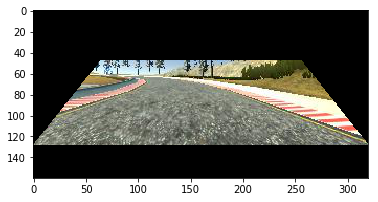

In [188]:
plt.imshow(crop_roi(sample_imgs[5]))
plt.show()

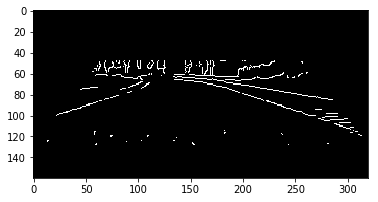

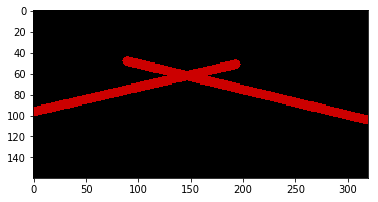

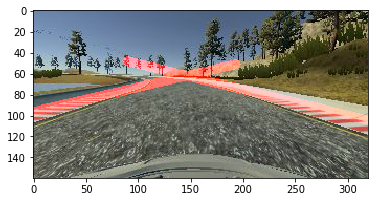

In [189]:
image = sample_imgs[0]
gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 200
high_threshold = 210
edges = canny(blur_gray, low_threshold, high_threshold)

masked_edges = crop_roi(edges)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 32    # minimum number of votes (intersections in Hough grid cell)
    
min_line_length = 3 #minimum number of pixels making up a line
max_line_gap = 40    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
color_edges = hough_lines3(masked_edges, rho, theta, threshold, 
                           min_line_length, max_line_gap)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    
plt.imshow(masked_edges, cmap='gray')
plt.show()

plt.imshow(lines_edges, cmap='gray')
plt.show()
    
plt.imshow(weighted_img(lines_edges, image))
plt.show()

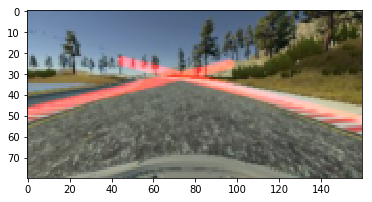

In [194]:
plt.imshow(resize(weighted_img(lines_edges, image), (80, 160)))
plt.show()

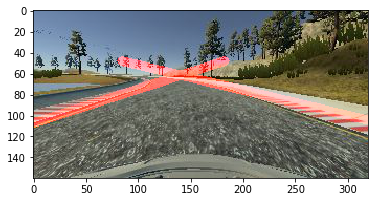

In [190]:
plt.imshow(weighted_img(find_lane3(sample_imgs[0]), sample_imgs[0]))
plt.show()

In [52]:
sample_preprocessed_img = _preprocess_image(sample_imgs[0], size=(128,128), 
                            apply_normalize=False)

In [53]:
sample_preprocessed_img.shape

(160, 320, 3)

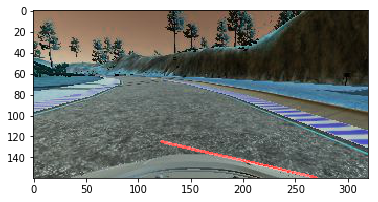

In [54]:
plt.imshow(sample_preprocessed_img)
plt.show()

### Steering Angles

In [19]:
steering_angles = driving_log_pd['steering_angle'].tolist()

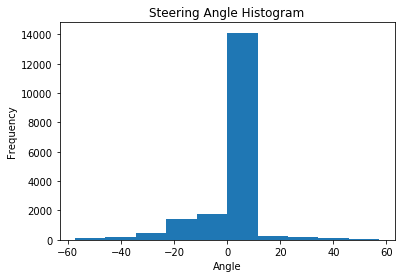

In [20]:
n, bins, patches = plt.hist([degrees(x) for x in steering_angles])
plt.title("Steering Angle Histogram")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

In [21]:
print("steering angle range: %3f-%3f" % (degrees(min(steering_angles)), degrees(max(steering_angles))))

steering angle range: -57.295780-57.295780


## Data

In [22]:
def split_train_test(img_steering_pd, train_perc=0.7, val_perc=0.2):
    idx_len = len(img_steering_pd.index)
    idxs = list(range(idx_len))
    shuffle(idxs)
    
    idx1 = int(idx_len*train_perc)
    idx2 = idx1 + int(idx_len*val_perc)
    
    train_pd = img_steering_pd.iloc[idxs[:idx1]]
    val_pd = img_steering_pd.iloc[idxs[idx1:idx2]]
    test_pd = img_steering_pd.iloc[idxs[idx2:]]
    
    return train_pd, val_pd, test_pd

In [23]:
import os

In [24]:
train_pd_file = '%s/train.p' % data_dir
val_pd_file = '%s/val.p' % data_dir
test_pd_file = '%s/test.p' % data_dir

if not os.path.exists(train_pd_file) or not os.path.exists(val_pd_file) \
    or not os.path.exists(test_pd_file):
    train_pd, val_pd, test_pd = split_train_test(driving_log_pd)
    train_pd.to_pickle(train_pd_file)
    val_pd.to_pickle(val_pd_file)
    test_pd.to_pickle(test_pd_file)
else:
    train_pd = pd.read_pickle(train_pd_file)
    val_pd = pd.read_pickle(val_pd_file)
    test_pd = pd.read_pickle(test_pd_file)    

In [26]:
_train_pd = smooth_steering_angle(train_pd)
_train_pd.iloc[:50]

,center_img,left_img,right_img,throttle,break,speed,steering_angle,mean_steering_angle
15528,center_2018_01_22_19_48_44_719.jpg,left_2018_01_22_19_48_44_719.jpg,right_2018_01_22_19_48_44_719.jpg,0.000000,0.0,13.814640,-0.046760,-0.014028
16939,center_2018_01_22_19_51_05_152.jpg,left_2018_01_22_19_51_05_152.jpg,right_2018_01_22_19_51_05_152.jpg,0.000000,0.0,15.345800,0.000000,0.000000
10168,center_2018_01_22_19_39_56_741.jpg,left_2018_01_22_19_39_56_741.jpg,right_2018_01_22_19_39_56_741.jpg,0.000000,0.0,10.923440,0.000000,0.000000
2977,center_2018_01_22_19_27_59_056.jpg,left_2018_01_22_19_27_59_056.jpg,right_2018_01_22_19_27_59_056.jpg,0.127536,0.0,8.934675,-0.337013,-0.202208
13879,center_2018_01_22_19_46_02_332.jpg,left_2018_01_22_19_46_02_332.jpg,right_2018_01_22_19_46_02_332.jpg,0.000000,0.0,13.931570,0.000000,0.000000
9978,center_2018_01_22_19_39_37_672.jpg,left_2018_01_22_19_39_37_672.jpg,right_2018_01_22_19_39_37_672.jpg,0.000000,0.0,6.943913,-0.510482,-0.306289
7917,center_2018_01_22_19_36_13_744.jpg,left_2018_01_22_19_36_13_744.jpg,right_2018_01_22_19_36_13_744.jpg,0.000000,0.0,8.825948,0.000000,0.000000
5194,center_2018_01_22_19_31_40_322.jpg,left_2018_01_22_19_31_40_322.jpg,right_2018_01_22_19_31_40_322.jpg,0.454056,0.0,16.696380,0.000000,0.000000
2280,center_2018_01_22_19_26_46_064.jpg,left_2018_01_22_19_26_46_064.jpg,right_2018_01_22_19_26_46_064.jpg,0.000000,0.0,10.846300,0.000000,0.000000
7631,center_2018_01_22_19_35_43_704.jpg,left_2018_01_22_19_35_43_704.jpg,right_2018_01_22_19_35_43_704.jpg,0.225606,0.0,10.563570,-0.026868,-0.016121


In [30]:
_driving_log_pd = load_data(data_dir, smooth_angle=True)
_driving_log_pd.iloc[:50]

,center_img,left_img,right_img,steering_angle,throttle,break,speed,mean_steering_angle
0,center_2018_01_22_19_22_53_312.jpg,left_2018_01_22_19_22_53_312.jpg,right_2018_01_22_19_22_53_312.jpg,0.000000,0.000000,0.000000,5.544637,0.000000
1,center_2018_01_22_19_22_53_419.jpg,left_2018_01_22_19_22_53_419.jpg,right_2018_01_22_19_22_53_419.jpg,0.000000,0.000000,0.000000,5.489003,0.000000
2,center_2018_01_22_19_22_53_517.jpg,left_2018_01_22_19_22_53_517.jpg,right_2018_01_22_19_22_53_517.jpg,0.000000,0.000000,0.000000,5.433926,0.000000
3,center_2018_01_22_19_22_53_589.jpg,left_2018_01_22_19_22_53_589.jpg,right_2018_01_22_19_22_53_589.jpg,0.000000,0.000000,0.000000,5.390263,0.000000
4,center_2018_01_22_19_22_53_690.jpg,left_2018_01_22_19_22_53_690.jpg,right_2018_01_22_19_22_53_690.jpg,0.000000,0.000000,0.000000,5.336177,0.000000
5,center_2018_01_22_19_22_53_762.jpg,left_2018_01_22_19_22_53_762.jpg,right_2018_01_22_19_22_53_762.jpg,0.000000,0.000000,0.000000,5.303978,0.000000
6,center_2018_01_22_19_22_53_846.jpg,left_2018_01_22_19_22_53_846.jpg,right_2018_01_22_19_22_53_846.jpg,0.000000,0.000000,0.000000,5.261351,0.000000
7,center_2018_01_22_19_22_53_945.jpg,left_2018_01_22_19_22_53_945.jpg,right_2018_01_22_19_22_53_945.jpg,0.000000,0.000000,0.000000,5.208557,0.000000
8,center_2018_01_22_19_22_54_050.jpg,left_2018_01_22_19_22_54_050.jpg,right_2018_01_22_19_22_54_050.jpg,0.000000,0.000000,0.000000,5.145902,0.000000
9,center_2018_01_22_19_22_54_143.jpg,left_2018_01_22_19_22_54_143.jpg,right_2018_01_22_19_22_54_143.jpg,-0.150000,0.000000,0.000000,5.100726,-0.090000


### Preprocessing Images

The images will be preprocessed with the following steps:
1. Crop
    * The top and bottom of the images will be cropped to reduce the size of the input.
2. Normalization
    * The images are normalized with a range of -0.5 to 0.5.

In [24]:
X_train_files = train_pd['center_img'].tolist()
y_train = np.array(train_pd['steering_angle'])

In [25]:
X_val = preprocess_images(read_imgs(img_dir, val_pd['center_img'].tolist()), x0=0, y0=48, x1=None, y1=112)
y_val = np.array(val_pd['steering_angle'])
X_test = preprocess_images(read_imgs(img_dir, test_pd['center_img'].tolist()), x0=0, y0=48, x1=None, y1=112)
y_test = np.array(test_pd['steering_angle'])

## Model

In [26]:
def make_model(input_shape = (64, 320, 3), p = 0.5):
    model = Sequential()

    # block 1
    model.add(Conv2D(8, (3, 3), strides=(1, 1), padding='same', 
                     activation='relu', input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    # block 2
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    # block 3
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
          
    model.add(Flatten())          
 
    model.add(Dense(64, activation=None))
    model.add(Dropout(p))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    return model

In [27]:
def image_gen(X_files, y, batch_size, img_dir, y0=48, y1=112): 
    X_len = len(X_files)
    idxs = list(range(X_len))
    
    while True:
        shuffle(idxs)
        y = y[idxs]
        X_files = [X_files[i] for i in idxs]
        
        for i in range(0, X_len, batch_size):
            end_idx = i+batch_size
            
            if end_idx > X_len:
                continue   
  
            curr_y = y[i:end_idx]
            curr_X_files = X_files[i:end_idx]
            curr_X = read_imgs(img_dir, curr_X_files)
            
            curr_X = preprocess_images(curr_X, y0=y0, y1=y1)

            yield curr_X, curr_y

## Train Model (primary data)

In [28]:
def train_model(model, X_train_files, y_train, img_dir, X_val, y_val, 
                batch_size=32, lr=0.0001, epochs=10, workers=1):
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

    train_gen = image_gen(X_train_files, y_train, batch_size, img_dir)

    steps_per_epoch = int(len(X_train_files)/batch_size)
    model.fit_generator(train_gen, validation_data=(X_val, y_val), 
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, workers=workers)   
    
    return model

In [ ]:
workers=6

In [29]:
model = make_model(input_shape = (64, 320, 3), p = 0.5)

In [30]:
model_graph_file = '%s/model.png' % data_dir
plot_model(model, to_file=model_graph_file)

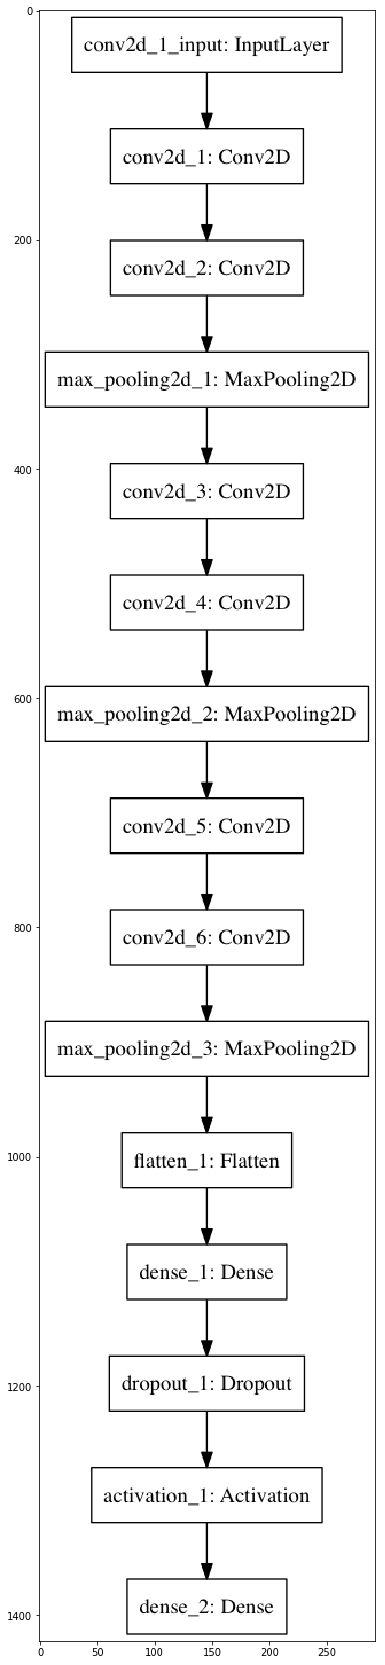

In [35]:
model_graph_img = imread(model_graph_file)

plt.figure(figsize=(50, 30))
plt.imshow(model_graph_img)
plt.show()

In [34]:
batch_size = 32

model = train_model(model, X_train_files, y_train, img_dir, X_val, y_val, workers=workers)

Epoch 1/10
407/407 [==============================] - 91s 223ms/step - loss: 0.0275 - val_loss: 0.0248
Epoch 2/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 3/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0241 - val_loss: 0.0241
Epoch 4/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 5/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0234 - val_loss: 0.0237
Epoch 6/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 7/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0226 - val_loss: 0.0235
Epoch 8/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0221 - val_loss: 0.0235
Epoch 9/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0218 - val_loss: 0.0234
Epoch 10/10
407/407 [==============================] - 48s 117ms/step - l

In [35]:
test_loss = model.evaluate(X_test, y_test)
print("test loss: %3f" % test_loss)

1866/1866 [==============================] - 2s 1ms/step
test loss: 0.021728


In [36]:
model.save('%s/model.h5'%data_dir)

## Fine tune model with extra data

The first model has problems right after the bridge.  It doesn't bank left hard enough and it ends up driving off the road. Train the model with extra data from just that section of the track. The learning rate of 0.0001 will be used, same as the first model.  All of the extra data will be used for training. The validation data from the first model will be reused.

In [37]:
def fine_tune_model_train(fine_tune_data_dir, model_file, X_val, y_val,
                           lr=0.0001, batch_size= 32, epochs=10, workers=1):
    # data
    train_pd = load_data(fine_tune_data_dir)
    fine_tune_img_dir = '%s/IMG' % fine_tune_data_dir
    
    X_train_files = train_pd['center_img'].tolist()
    y_train = np.array(train_pd['steering_angle'])
    train_gen = image_gen(X_train_files, y_train, batch_size, fine_tune_img_dir)
    
    # model
    model = load_model(model_file)
    
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

    steps_per_epoch = int(len(X_train_files)/batch_size)
    model.fit_generator(train_gen, validation_data=(X_val, y_val), 
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, workers=workers)
    
    return model

In [38]:
extra_data_dir = 'data/data_extra'

In [41]:
model_file = '%s/model.h5' % data_dir
model2 = fine_tune_model_train(extra_data_dir, model_file, X_val, y_val, workers=workers)

Epoch 1/10
19/19 [==============================] - 6s 338ms/step - loss: 0.0356 - val_loss: 0.0244
Epoch 2/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0331 - val_loss: 0.0245
Epoch 3/10
19/19 [==============================] - 6s 317ms/step - loss: 0.0326 - val_loss: 0.0245
Epoch 4/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0293 - val_loss: 0.0248
Epoch 5/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0305 - val_loss: 0.0252
Epoch 6/10
19/19 [==============================] - 6s 317ms/step - loss: 0.0293 - val_loss: 0.0252
Epoch 7/10
19/19 [==============================] - 6s 319ms/step - loss: 0.0293 - val_loss: 0.0256
Epoch 8/10
19/19 [==============================] - 6s 319ms/step - loss: 0.0261 - val_loss: 0.0256
Epoch 9/10
19/19 [==============================] - 6s 320ms/step - loss: 0.0270 - val_loss: 0.0256
Epoch 10/10
19/19 [==============================] - 6s 320ms/step - loss: 0.0228 - val_loss: 0.0262

In [42]:
test_loss2 = model2.evaluate(X_test, y_test)
print("test loss: %3f" % test_loss)

1866/1866 [==============================] - 2s 1ms/step
test loss: 0.021728


In [43]:
model2_file = '%s/model.h5' % extra_data_dir
model2.save(model2_file)